# ML PROJECT 
---

Authors
 Andrea Scarpellini 
 Martina Scarpellini 


## DATASET EXPLORATION


In [1]:
import pandas as pd
import numpy as np

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

At first, we imported the dataset and printed it. 
It has 3000 rows and 16 columns.

In [2]:
df = pd.read_csv('tyres_train.csv')
print(df.shape)

(3000, 16)


In [3]:
df.head()

,vulc,perc_nat_rubber,wiring_strength,weather,perc_imp,temperature,tread_type,tyre_season,elevation,month,tread_depth,tyre_quality,perc_exp_comp,diameter,add_layers,failure
0,17.990,26,1,0.16,0.01,-8.12,0,1,332.5,8,0,1,5.13,55.0,1,0
1,20.704,36,1,0.30,0.01,-4.52,2,0,328.0,11,1,0,6.15,NaN,1,0
2,19.156,34,1,0.30,0.01,-1.08,0,0,247.0,0,1,0,6.36,NaN,1,0
3,16.802,35,1,0.19,0.02,7.44,1,0,408.0,7,3,1,6.62,54.5,1,0
4,17.140,23,2,0.39,0.01,30.52,0,1,308.0,2,2,0,6.15,76.3,1,0


### CLASS COUNTS

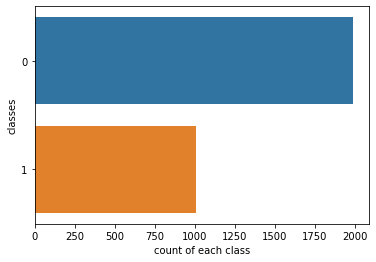

In [4]:
#Visualize Class Counts
sns.countplot(y=df.failure ,data=df) 
plt.xlabel("count of each class")
plt.ylabel("classes")
plt.show()

 Since the upper barchart shows us an imbalanced dataset, our analysis will be characterized as follow:
- Classification with original training data set 
- Classification with oversampled training data set


### MISSING VALUES

We wanted to look for missing values in our dataset.
We noticed that the coloumn 'diameter' was the only one with at least one missing value
(because it was the only one that gave 'true' as output).

In [5]:
#in which column of our dataset is there at least a missing values?
df.isna().any()

vulc               False
perc_nat_rubber    False
wiring_strength    False
weather            False
perc_imp           False
temperature        False
tread_type         False
tyre_season        False
elevation          False
month              False
tread_depth        False
tyre_quality       False
perc_exp_comp      False
diameter            True
add_layers         False
failure            False
dtype: bool

In [6]:
#percentage of NaN values in "diameter"
a=df['diameter'].isna().sum();
print("NaN value in diameter:",a)
print("Perc of NaN:", a/len(df)*100,"%")
print("\nDivided in:")
print(df[df['failure']==0]['diameter'].isna().sum(),"failure 0")
print(df[df['failure']==1]['diameter'].isna().sum(),"failure 1")


NaN value in diameter: 2110
Perc of NaN: 70.33333333333334 %

Divided in:
1407 failure 0
703 failure 1


We searched the percentage of Nan values in the diameter.
We found that it was more than 70%.
We decided to omit the diameter attribute from our analysis.

We listed all the attributes:
Attributes: 
- vulc            Numerical 
- perc_nat_rubber Numerical
- weather         Numerical
- perc_imp        Numerical
- temperature     Numerical 
- elevation       Numerical
- perc_exp_comp   Numerical
- diameter        Numerical
- tread_type      Categorical 
- tyre_season     Categorical 
- month           Categorical 
- tread_depth     Categorical 
- wiring_strenght Categorical
- tyre_quality    Categorical 
- add_layers      Categorical


Categorical attributes assume a finite number of distinct values, in most cases limited to less than a hundred, representing a qualitative property of
an entity to which they refer.
Numerical attributes assume a finite or infinite number of values and lend themselves to subtraction or division operations.

Numerical attributes are one that may take on any value within a finite or infinite interval. 

We identified the datatype of our data.
Some of the data are integers and some others are float. 

In [7]:
#come trattiamo le variabili categoriche 
print(df.dtypes)

vulc               float64
perc_nat_rubber      int64
wiring_strength      int64
weather            float64
perc_imp           float64
temperature        float64
tread_type           int64
tyre_season          int64
elevation          float64
month                int64
tread_depth          int64
tyre_quality         int64
perc_exp_comp      float64
diameter           float64
add_layers           int64
failure              int64
dtype: object


In [8]:
cat=df[["tyre_season","month", "tread_depth","wiring_strength","tyre_quality","tread_type","add_layers" ]]
num=df[["vulc","perc_nat_rubber","weather","perc_imp","temperature", "elevation", "perc_exp_comp"]]

print(cat.shape)
print(num.shape)

(3000, 7)
(3000, 7)


### CATEGORICAL DATA

In [9]:
cat.head()

,tyre_season,month,tread_depth,wiring_strength,tyre_quality,tread_type,add_layers
0,1,8,0,1,1,0,1
1,0,11,1,1,0,2,1
2,0,0,1,1,0,0,1
3,0,7,3,1,1,1,1
4,1,2,2,2,0,0,1


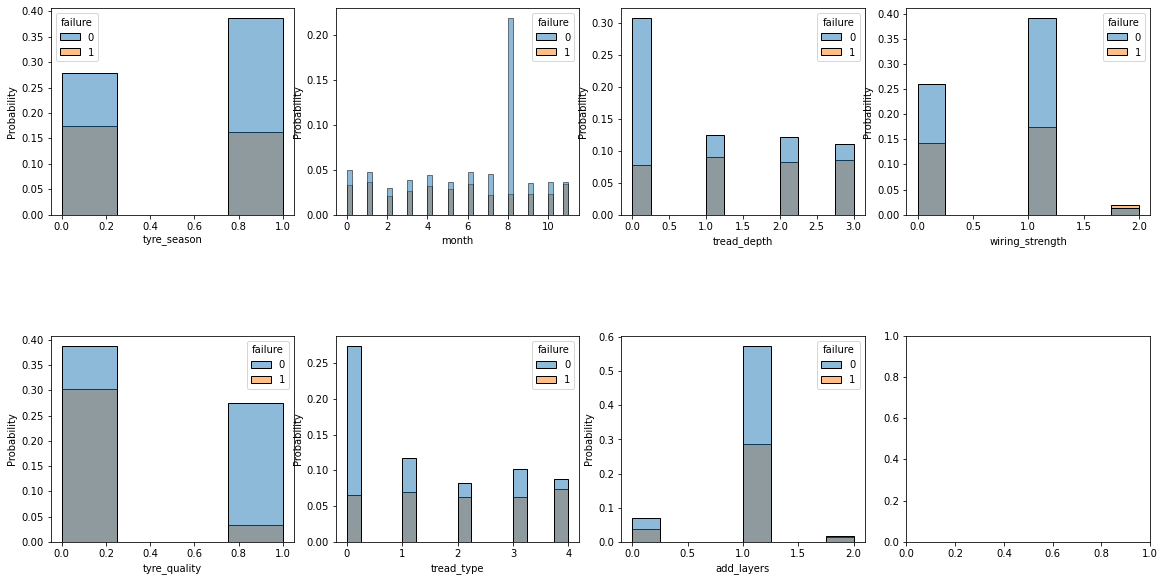

In [10]:
cat_plot=df[["tyre_season","month","tread_depth","wiring_strength","tyre_quality","tread_type","add_layers","failure"]]
fig, axes = plt.subplots(2, 4,figsize=[16,8])
axes = axes.flatten()
fig.tight_layout(h_pad=10)
i=0
for x in cat.columns:
    sns.histplot(data=cat_plot, x=x, hue="failure",stat ='probability' , ax=axes[i], binwidth=1/4 ,bins=len(set(cat_plot[x])))
    i=i+1
plt.show()

We can observe a peak of 0 labeled observations in correspondence of "month" = 8.This could be a noise-affected attribute.

So let's say how many 0 observation we have in september.

In [11]:
#try to correct month 8
print(((df['month']==8) & (df['failure']==0)).sum())
print(((df['month']==8) & (df['failure']==1)).sum())

#too many items to delete o change the labels --> so i wont consider the month column 

655
69


### ENTROPY  e  GINI 

We can measure homogeneity and heterogeneity of the data. In this way we can better understand how the failure distribution behave for each categorical attribute.

In [12]:
import collections
def CountFrequency(arr):
    return collections.Counter(arr)

def entropy(x):
    e=0
    for i in range(0,len(set(x))):
        e=e+CountFrequency(x)[i]/len(x) * np.log2( CountFrequency(x)[i]/len(x) )
    return -e 

#gini function 
def gini(x):
    tot=0
    for i in range(0,len(set(x))):
        tot=tot+ (CountFrequency(x)[i]/len(x))**2
    return 1-tot 


In [13]:
categories=['tyre_season','month','tread_depth','wiring_strength','tyre_quality','tread_type','add_layers'];

print("GINI --> 0.5 MAX ETEROGENETY\nGINI --> 0.0 MAX HOMOGENEITY**")
print("EI   --> 1   MAX ETEROGENETY\nEI   --> 0.0 MAX HOMOGENEITY**\n\n")
#gini index for categories:
for j in categories:
    print("-->",j,":\n")
    for i in set(df[j]):
        lis=(np.array([df[df[j]==i]['failure']])).astype(int)
        print(j ,"=",i) 
        print('Gini index:', round(gini(lis[0]),3), " || Entropy index:", round(entropy(lis[0]),3))
    
    print("##")
    print("\n")


GINI --> 0.5 MAX ETEROGENETY
GINI --> 0.0 MAX HOMOGENEITY**
EI   --> 1   MAX ETEROGENETY
EI   --> 0.0 MAX HOMOGENEITY**


--> tyre_season :

tyre_season = 0
Gini index: 0.474  || Entropy index: 0.962
tyre_season = 1
Gini index: 0.416  || Entropy index: 0.875
##


--> month :

month = 0
Gini index: 0.48  || Entropy index: 0.97
month = 1
Gini index: 0.491  || Entropy index: 0.987
month = 2
Gini index: 0.486  || Entropy index: 0.98
month = 3
Gini index: 0.482  || Entropy index: 0.973
month = 4
Gini index: 0.487  || Entropy index: 0.981
month = 5
Gini index: 0.492  || Entropy index: 0.988
month = 6
Gini index: 0.489  || Entropy index: 0.983
month = 7
Gini index: 0.442  || Entropy index: 0.915
month = 8
Gini index: 0.172  || Entropy index: 0.454
month = 9
Gini index: 0.476  || Entropy index: 0.965
month = 10
Gini index: 0.474  || Entropy index: 0.962
month = 11
Gini index: 0.499  || Entropy index: 0.999
##


--> tread_depth :

tread_depth = 0
Gini index: 0.321  || Entropy index: 0.724
tread

The high difference between the target distrbution in september is highlighted also by the gini and entropy indexes  

### DUMMIES
To properly treat the categorical variables, we first need to define N-1 binary variables Dj1,Dj2....DjN-1, called dummies varibles.

In [14]:
#categorical variables have the "object" type
#Categorical variables must be changed in the pre-processing section
#since machine learning models require numeric input variables
cat = cat.astype(str)
cat.dtypes

tyre_season        object
month              object
tread_depth        object
wiring_strength    object
tyre_quality       object
tread_type         object
add_layers         object
dtype: object

In [15]:
selection_categorical=['tyre_season','tread_depth','wiring_strength','tyre_quality','tread_type','add_layers'];
dummies = pd.get_dummies(cat[selection_categorical]) 
dummies.tail()

,tyre_season_0,tyre_season_1,tread_depth_0,tread_depth_1,tread_depth_2,tread_depth_3,wiring_strength_0,wiring_strength_1,wiring_strength_2,tyre_quality_0,tyre_quality_1,tread_type_0,tread_type_1,tread_type_2,tread_type_3,tread_type_4,add_layers_0,add_layers_1,add_layers_2
2995,0,1,0,1,0,0,0,0,1,0,1,0,1,0,0,0,0,1,0
2996,0,1,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,1,0
2997,1,0,0,0,0,1,0,1,0,0,1,0,1,0,0,0,1,0,0
2998,1,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,1,0,0
2999,1,0,0,1,0,0,0,0,1,1,0,0,1,0,0,0,1,0,0


### NUMERICAL DATA

In [16]:
num.head()

,vulc,perc_nat_rubber,weather,perc_imp,temperature,elevation,perc_exp_comp
0,17.990,26,0.16,0.01,-8.12,332.5,5.13
1,20.704,36,0.30,0.01,-4.52,328.0,6.15
2,19.156,34,0.30,0.01,-1.08,247.0,6.36
3,16.802,35,0.19,0.02,7.44,408.0,6.62
4,17.140,23,0.39,0.01,30.52,308.0,6.15


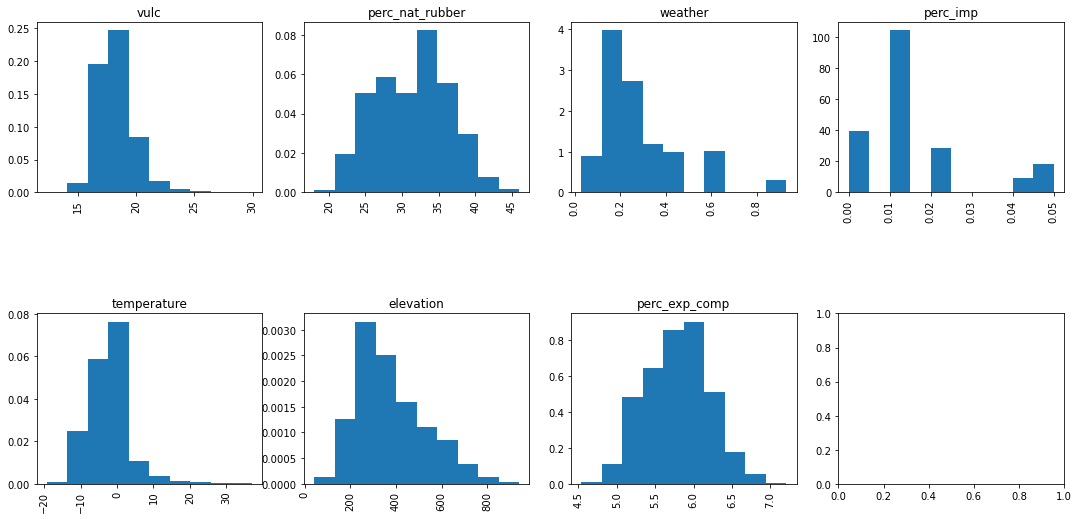

In [17]:
fig, axes = plt.subplots(2, 4,figsize=[15,7])
axes = axes.flatten()
fig.tight_layout(h_pad=10)

i=0
for x in num.columns:
    plt.sca(axes[i]) # set the current Axes
    plt.hist(num[x],density=True)
    plt.xticks(rotation = 90) # Rotates X-Axis Ticks by 45-degrees
    plt.title(x)
    i+=1
plt.show()

array([[<AxesSubplot:title={'center':'vulc'}>,
        <AxesSubplot:title={'center':'logvulc'}>,
        <AxesSubplot:title={'center':'weather'}>,
        <AxesSubplot:title={'center':'logweather'}>,
        <AxesSubplot:title={'center':'perc_imp'}>],
       [<AxesSubplot:title={'center':'logpercimp'}>,
        <AxesSubplot:title={'center':'elevation'}>,
        <AxesSubplot:title={'center':'logelevation'}>,
        <AxesSubplot:title={'center':'logtemperature'}>,
        <AxesSubplot:title={'center':'temperature'}>]], dtype=object)

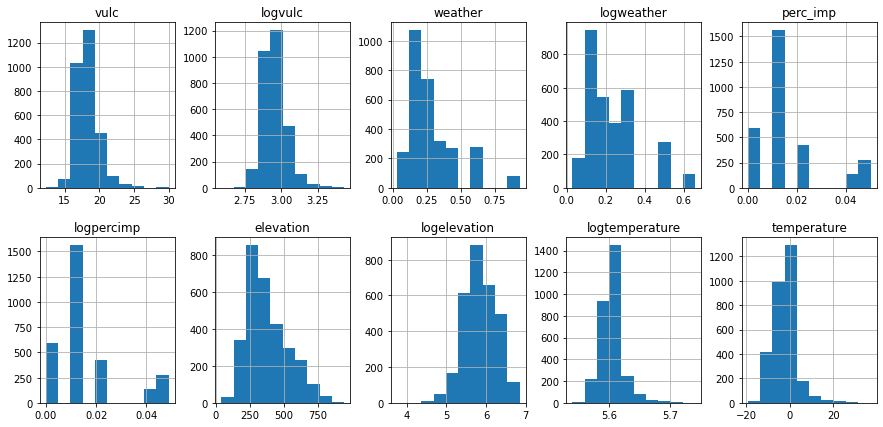

In [18]:
import math
pd.options.mode.chained_assignment = None # no warning on creating a new column

num['logvulc']=num['vulc'].apply(lambda x: math.log(x+1))
num['logweather']=num['weather'].apply(lambda x: math.log(x+1))
num['logpercimp']=num['perc_imp'].apply(lambda x: math.log(x+1))
num['logelevation']=num['elevation'].apply(lambda x: math.log(x+1))
num['logtemperature']=(num['temperature']+273.15).apply(lambda x: math.log(x+1))
num[['vulc','logvulc',
     'weather','logweather',
     'perc_imp','logpercimp',
     'elevation','logelevation',
     'logtemperature','temperature']].hist(layout=(2,5), figsize=(15,7))

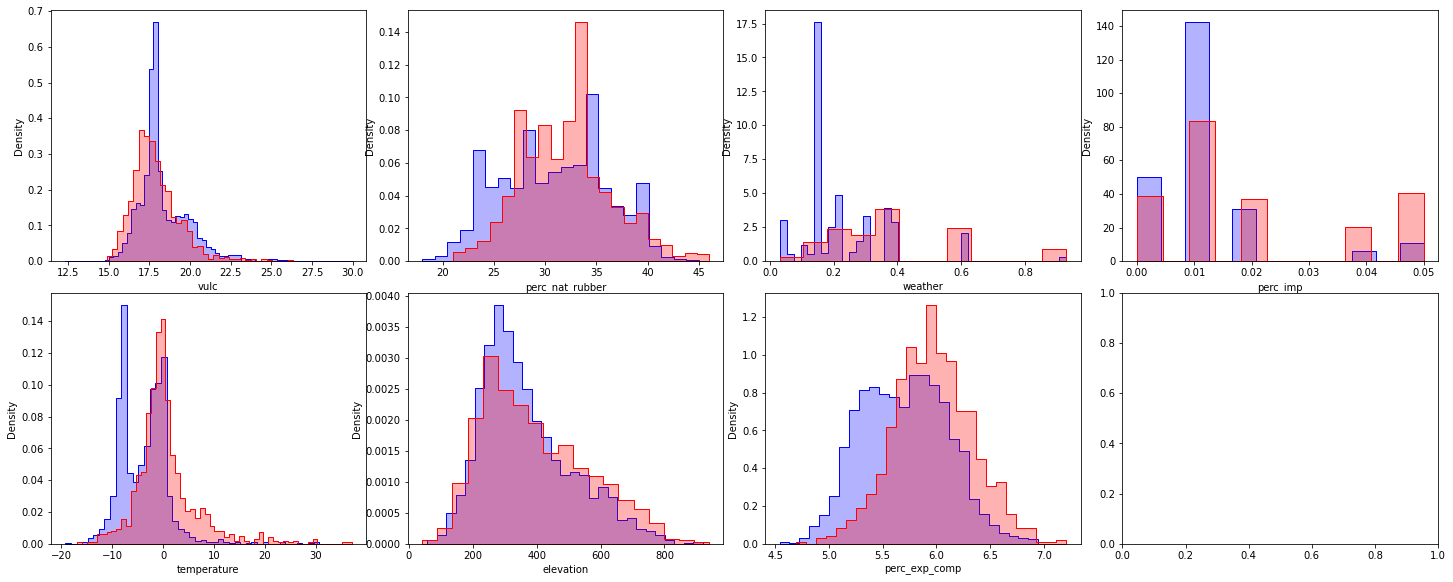

In [19]:
X0 = num[df['failure']==0]
X1 = num[df['failure']==1]

fig, axes = plt.subplots(ncols=4, nrows=2, figsize=(20,8))
fig.tight_layout()

for i, ax in zip(range(cat.columns.size), axes.flat):
    sns.histplot(X0.iloc[:,i], color="blue", ax=ax, stat='density', element="step",  alpha=0.3)
    sns.histplot(X1.iloc[:,i], color="red", ax=ax,stat='density', element="step",  alpha=0.3)
plt.show()

##provare ad applicare quache trasf

The log transformation distributions are quite similar to the orginal one so we kept the originals one. 
Since we do not exclude any numerical features except diameter and we do not apply any 
numerical transformation let's consider the columns of interest as follows:

In [20]:
#at the end let's take the column of interest 
num=df[["vulc", "perc_nat_rubber","weather","perc_imp","temperature","elevation","perc_exp_comp"]]

### ANALISI PCA 
The purpose of this method is to obtain a projective transformation that replaces a subset of the original numerical attributes with a lower number of new attributes obtained
as their linear combination, without this change causing a loss of information.

<AxesSubplot:>

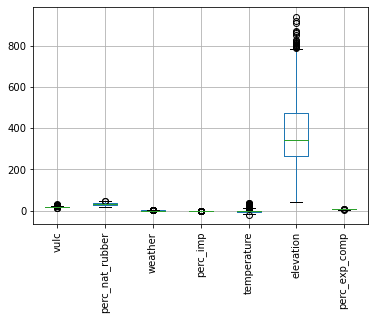

In [21]:
num.boxplot(rot=90)

#elevation has totally different numbers --> standardization 

to properly apply PCA analysis standardization is required 

In [22]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(num) # No target
scaled_num = pd.DataFrame(scaler.transform(num))
scaled_num.columns = num.columns
scaled_num.tail()

,vulc,perc_nat_rubber,weather,perc_imp,temperature,elevation,perc_exp_comp
2995,-0.231083,-0.456093,0.584065,-0.319087,1.702514,-0.586827,-0.271809
2996,-0.698653,-0.253355,-0.343773,-1.020379,0.164930,-1.480129,0.045070
2997,-1.269567,0.354859,0.584065,-0.319087,-0.187726,-0.934222,-0.539937
2998,0.433093,1.165810,-1.380768,-1.020379,0.284834,-0.570284,0.240072
2999,1.315301,0.354859,-1.217032,-1.020379,0.912563,0.190677,0.508200


<AxesSubplot:>

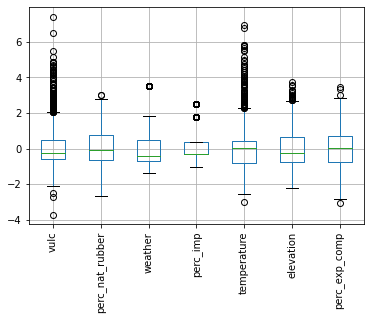

In [23]:
scaled_num.boxplot(rot=90)
#ok! 

In [24]:
#PCA fit
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(scaled_num) 

PCA()

In [25]:
#let's use the pca to transform the dataset
num_pca = pd.DataFrame(pca.transform(scaled_num))
num_pca.columns =['PC1','PC2','PC3','PC4','PC5','PC6','PC7']
num_pca

,PC1,PC2,PC3,PC4,PC5,PC6,PC7
0,-2.039807,-1.005052,0.143276,0.280682,-0.055187,0.362670,0.070427
1,0.230444,1.339307,1.267905,-0.763265,0.159000,-0.653739,-0.277058
2,0.623754,0.939546,0.072528,-1.191816,0.466955,-0.734820,-0.208645
3,1.967707,1.162369,-1.581563,-0.294469,0.319924,-0.303452,0.923830
4,2.771142,0.328019,-2.985996,-0.799060,3.063998,3.395502,-0.162010
...,...,...,...,...,...,...,...
2995,0.625458,-0.250981,-0.783154,-0.636191,0.673647,1.360141,-0.495100
2996,-0.779224,-0.093864,-1.159095,-1.344233,0.107791,-0.019557,-0.391418
2997,-0.118266,-0.862350,-0.778459,-0.789547,-1.028185,0.076134,-0.574664
2998,-0.695504,1.737254,-0.289416,-0.992616,-0.390970,0.111279,0.471484


In [26]:
pd.DataFrame(pca.components_,index=['PC1','PC2','PC3','PC4','PC5','PC6','PC7'],columns=num.columns)

,vulc,perc_nat_rubber,weather,perc_imp,temperature,elevation,perc_exp_comp
PC1,-0.080281,0.292608,0.509765,0.442437,0.469686,0.157051,0.455033
PC2,0.388180,0.472226,-0.373902,-0.496069,0.214217,0.262835,0.354203
PC3,0.796293,0.176996,0.232871,0.334312,-0.341043,0.047571,-0.223659
PC4,-0.104280,-0.256250,-0.006530,0.057527,-0.132234,0.945590,-0.092107
PC5,0.425614,-0.764839,-0.071712,0.003050,0.302535,-0.083554,0.360851
PC6,0.124018,0.013110,0.024990,-0.070775,0.705190,0.052928,-0.691896
PC7,-0.037241,0.096131,-0.735050,0.661871,0.104354,-0.008160,0.006628


In [27]:
pd.DataFrame(pca.explained_variance_).transpose()

,0,1,2,3,4,5,6
0,2.611119,1.17498,1.042926,0.946682,0.7149,0.332083,0.179644


          0         1        2         3         4         5         6
0  0.372893  0.167798  0.14894  0.135195  0.102095  0.047425  0.025655


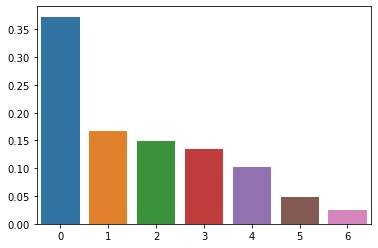

In [28]:
#VISUALIZE The percentage of variance explained by each of the selected components.
explained_var=pd.DataFrame(pca.explained_variance_ratio_).transpose()
print(explained_var)
ax = sns.barplot( data=explained_var)

In [29]:
cum_explained_var=np.cumsum(pca.explained_variance_ratio_)
cum_explained_var= pd.DataFrame(cum_explained_var).transpose()
cum_explained_var

,0,1,2,3,4,5,6
0,0.372893,0.540691,0.689631,0.824826,0.92692,0.974345,1.0


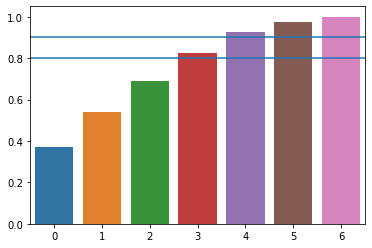

In [30]:
ax = sns.barplot(data=cum_explained_var)
ax.axhline(0.9)
ax.axhline(0.8)

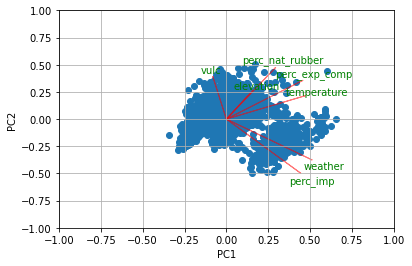

In [31]:
def myplot(score,coeff,labels=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    plt.scatter(xs * scalex,ys * scaley)
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        if labels is None:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'g', ha = 'center', va = 'center')
        else:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')
    plt.xlim(-1,1)
    plt.ylim(-1,1)
    plt.xlabel("PC{}".format(1))
    plt.ylabel("PC{}".format(2))
    plt.grid()

#Call the function. Use only the 2 PCs.
myplot(pca.transform(scaled_num)[:,0:2],np.transpose(pca.components_[0:2, :]), num.columns)
plt.show()



#perc_imp e wheater sono correlate? 

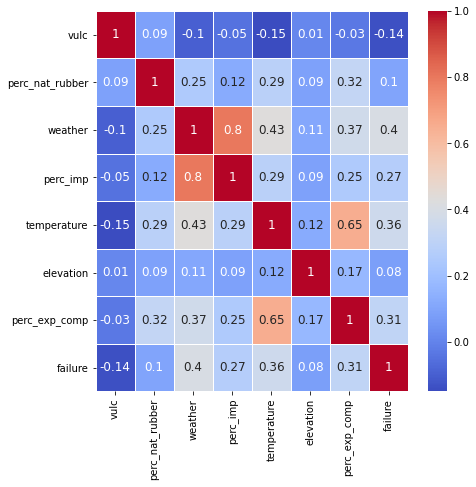

In [32]:
scaled_num['failure']=df['failure']
plt.figure(figsize = (7,7))
sns.heatmap(data=scaled_num.corr().round(2), cmap='coolwarm', linewidths=.5, annot=True, annot_kws={"size":12})
plt.show()

#We see that there is a numerical correlation between "weather" and "perc_imp"
#but we can not rationally explain it.

At the end of the PCA analysis we did not found any interest information to describe the data distribution in a convinient way. PCA was not useful to obtain a better interpretation of the data.  

## CLASSIFICATION 

In [33]:
num.head()

,vulc,perc_nat_rubber,weather,perc_imp,temperature,elevation,perc_exp_comp
0,17.990,26,0.16,0.01,-8.12,332.5,5.13
1,20.704,36,0.30,0.01,-4.52,328.0,6.15
2,19.156,34,0.30,0.01,-1.08,247.0,6.36
3,16.802,35,0.19,0.02,7.44,408.0,6.62
4,17.140,23,0.39,0.01,30.52,308.0,6.15


In [34]:
dummies.tail()

,tyre_season_0,tyre_season_1,tread_depth_0,tread_depth_1,tread_depth_2,tread_depth_3,wiring_strength_0,wiring_strength_1,wiring_strength_2,tyre_quality_0,tyre_quality_1,tread_type_0,tread_type_1,tread_type_2,tread_type_3,tread_type_4,add_layers_0,add_layers_1,add_layers_2
2995,0,1,0,1,0,0,0,0,1,0,1,0,1,0,0,0,0,1,0
2996,0,1,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,1,0
2997,1,0,0,0,0,1,0,1,0,0,1,0,1,0,0,0,1,0,0
2998,1,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,1,0,0
2999,1,0,0,1,0,0,0,0,1,1,0,0,1,0,0,0,1,0,0


### CREATION OF X AND Y 

In [58]:
X=pd.concat([num,dummies], axis = 1)
print(X.shape)
X.tail()

(3000, 26)


,vulc,perc_nat_rubber,weather,perc_imp,temperature,elevation,perc_exp_comp,tyre_season_0,tyre_season_1,tread_depth_0,...,tyre_quality_0,tyre_quality_1,tread_type_0,tread_type_1,tread_type_2,tread_type_3,tread_type_4,add_layers_0,add_layers_1,add_layers_2
2995,17.818,29,0.39,0.01,7.28,287.5,5.68,0,1,0,...,0,1,0,1,0,0,0,0,1,0
2996,17.076,30,0.22,0.00,-1.44,152.5,5.81,0,1,0,...,1,0,0,1,0,0,0,0,1,0
2997,16.170,33,0.39,0.01,-3.44,235.0,5.57,1,0,0,...,0,1,0,1,0,0,0,1,0,0
2998,18.872,37,0.03,0.00,-0.76,290.0,5.89,1,0,1,...,1,0,0,0,0,0,1,1,0,0
2999,20.272,33,0.06,0.00,2.80,405.0,6.00,1,0,0,...,1,0,0,1,0,0,0,1,0,0


In [59]:
y=df['failure']
print(len(y))

3000


### SPLIT DATA 

 - TRAIN SET 70%
 - TEST SET 30% 
 

In [60]:
from sklearn.model_selection import train_test_split

#SPLIT DATA INTO TRAIN AND TEST SET
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size =0.30,   
                                                    stratify=y,        #preserve target propotions (probviamo non stratificata)
                                                    random_state= 321) #fix random seed for replicability

print( X_train.shape, X_test.shape)

(2100, 26) (900, 26)


### SCALER
Only for the training set.

In [61]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(X_train[num.columns]) 
X_train[num.columns] = scaler.transform(X_train[num.columns])
#scaled_train_num.columns =num.columns

X_train.head()

,vulc,perc_nat_rubber,weather,perc_imp,temperature,elevation,perc_exp_comp,tyre_season_0,tyre_season_1,tread_depth_0,...,tyre_quality_0,tyre_quality_1,tread_type_0,tread_type_1,tread_type_2,tread_type_3,tread_type_4,add_layers_0,add_layers_1,add_layers_2
1478,-1.272006,0.538925,3.570635,1.802901,0.219643,-0.463013,1.196003,0,1,1,...,1,0,0,1,0,0,0,0,1,0
1575,0.580725,0.338475,-0.664065,-0.309088,-1.260420,0.804318,-1.124672,0,1,0,...,0,1,0,0,0,1,0,0,1,0
333,-0.755024,-1.064678,-1.269022,-1.013084,0.240787,3.226475,0.389873,0,1,1,...,1,0,1,0,0,0,0,0,1,0
1440,1.241596,-0.262876,0.545849,1.802901,1.904097,1.247718,1.391428,1,0,0,...,1,0,0,0,1,0,0,1,0,0
1023,-0.367924,-1.064678,-0.664065,-0.309088,-1.133558,0.483349,-1.149101,0,1,1,...,0,1,1,0,0,0,0,0,1,0


In [62]:
#Now lets's apply the scaler to the test set 
X_test[num.columns] = scaler.transform(X_test[num.columns])
X_test.head()

,vulc,perc_nat_rubber,weather,perc_imp,temperature,elevation,perc_exp_comp,tyre_season_0,tyre_season_1,tread_depth_0,...,tyre_quality_0,tyre_quality_1,tread_type_0,tread_type_1,tread_type_2,tread_type_3,tread_type_4,add_layers_0,add_layers_1,add_layers_2
364,-1.459189,-0.062426,-0.939045,-1.013084,-0.372382,-1.128113,0.927293,1,0,1,...,1,0,1,0,0,0,0,0,1,0
2163,-0.244409,-1.465579,-0.664065,-0.309088,-1.056030,-0.099028,-1.149101,0,1,1,...,0,1,1,0,0,0,0,0,1,0
12,-0.278789,-1.465579,-0.664065,-0.309088,-0.851641,-0.565591,-0.562825,0,1,1,...,0,1,1,0,0,0,0,0,1,0
606,0.333694,-1.866480,0.490853,0.394908,3.856371,1.611703,1.122718,0,1,0,...,1,0,0,1,0,0,0,0,1,0
2939,-0.552561,0.138024,-0.609069,-0.309088,-0.111609,-0.486176,-0.367399,1,0,0,...,1,0,0,0,0,0,1,0,1,0


In [40]:
#Save the scaler
import pickle
pickle.dump(scaler, open('scaler_NOT_OVERSAMPLED.pkl', 'wb'))

C:\Users\scrpa\miniconda3\envs\myenv\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
C:\Users\scrpa\miniconda3\envs\myenv\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


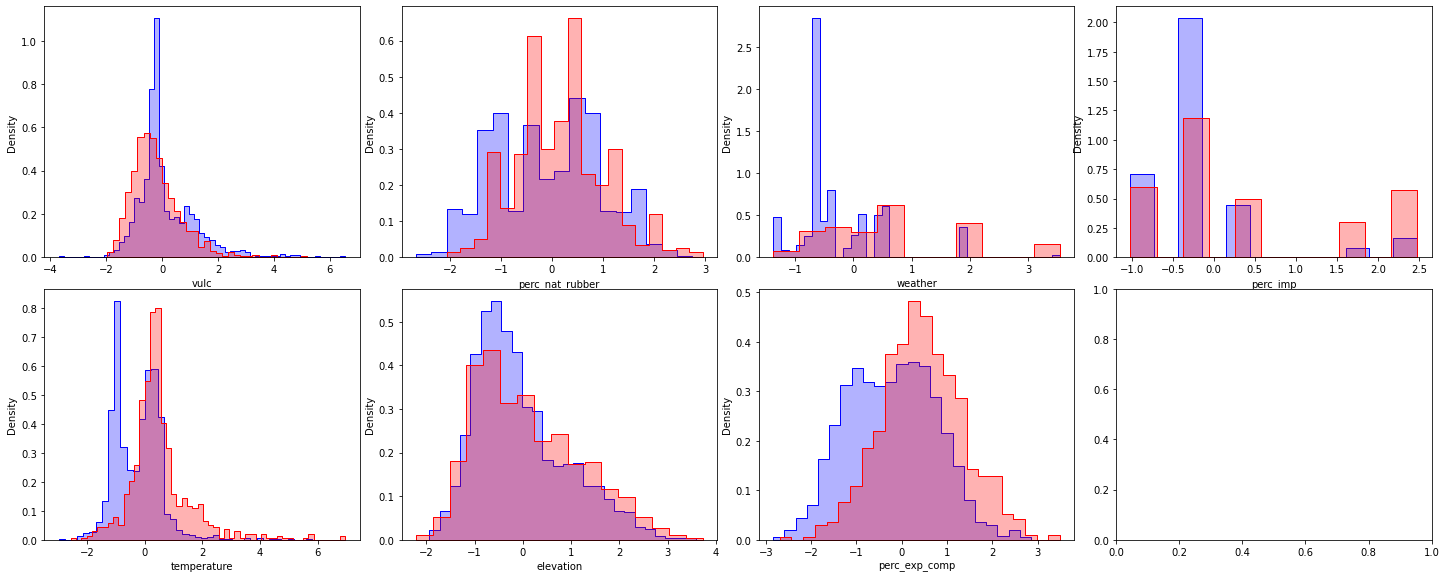

In [41]:
X0 = X_train[df['failure']==0]
X1 = X_train[df['failure']==1]

fig, axes = plt.subplots(ncols=4, nrows=2, figsize=(20,8))
fig.tight_layout()

for i, ax in zip(range(num.columns.size), axes.flat):
    sns.histplot(X0.iloc[:,i], color="blue", ax=ax, stat='density', element="step",  alpha=0.3)
    sns.histplot(X1.iloc[:,i], color="red", ax=ax,stat='density', element="step",  alpha=0.3)
plt.show()

---
### DATA DISCRETIZATION

In order to make learning algorithms more efficient we perfrom also a data discretization of some numerical attributes. 

The general purpose of data reduction methods is to obtain a decrease in the number of distinct values assumed by one or more attributes. Data discretization is the primary reduction method. On the one hand, it reduces continuous attributes to categorical attributes characterized by a limited number of distinct values. On the other hand, its aim is to significantly reduce the number of
distinct values assumed by the categorical attributes



(do not run the following cells to the optimal analysis--> skip to the "model" section)

In [132]:
from sklearn.preprocessing import KBinsDiscretizer

sel=['vulc','temperature','elevation','perc_nat_rubber','perc_exp_comp']
# transform the dataset with KBinsDiscretizer
enc = KBinsDiscretizer(n_bins=10, encode="ordinal")
for  i in sel:
    X_train[i] = enc.fit_transform((np.array(X_train[i])).reshape(-1, 1))
    X_test[i]=   enc.fit_transform((np.array(X_test[i])).reshape(-1, 1))

C:\Users\scrpa\miniconda3\envs\myenv\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
C:\Users\scrpa\miniconda3\envs\myenv\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


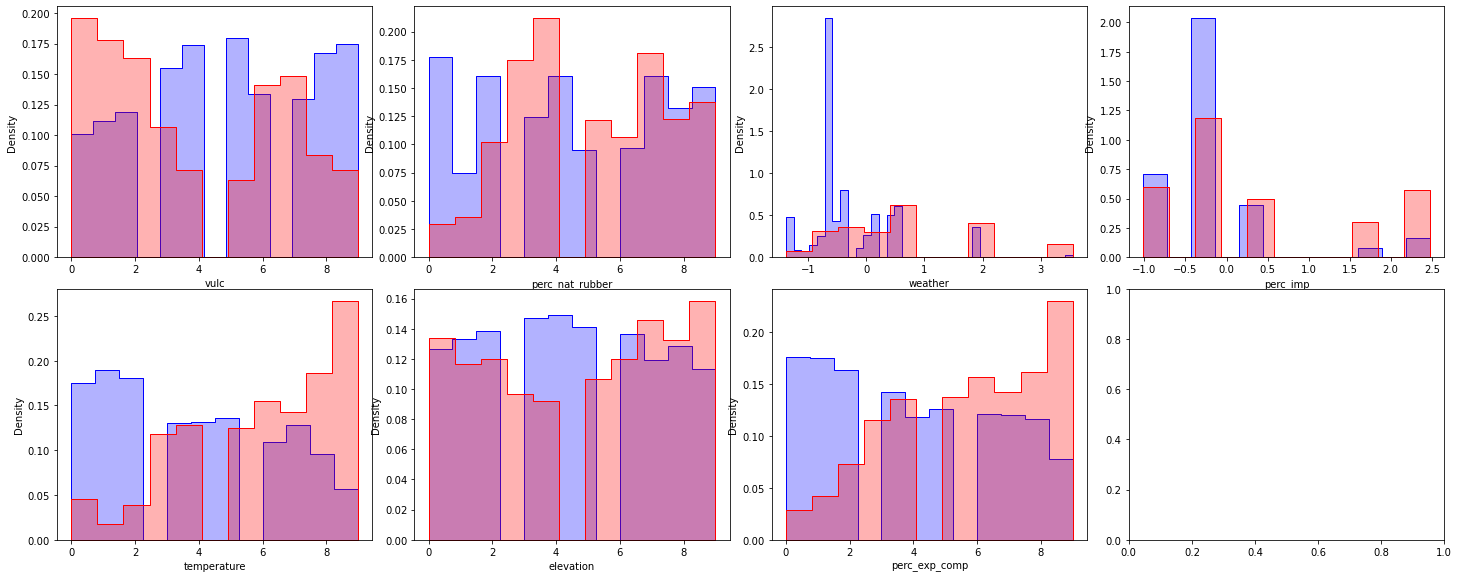

Result of the data discretization


In [133]:
X0 = X_train[df['failure']==0]
X1 = X_train[df['failure']==1]

fig, axes = plt.subplots(ncols=4, nrows=2, figsize=(20,8))
fig.tight_layout()

for i, ax in zip(range(num.columns.size), axes.flat):
    sns.histplot(X0.iloc[:,i], color="blue", ax=ax, stat='density', element="step",  alpha=0.3)
    sns.histplot(X1.iloc[:,i], color="red", ax=ax,stat='density', element="step",  alpha=0.3)
plt.show()

print("Result of the data discretization")

### NOT THE BEST CHOICHE DISCRETIZE !!!
---

### MODELS

In [42]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import metrics 
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score

In [43]:
#funzioni 


def hyperp_search(classifier, parameters):
    gs = GridSearchCV(classifier, parameters, cv=3, scoring = 'f1', verbose=10, n_jobs=-1)
    gs = gs.fit(X_train, y_train)
    print("f1_train: %f using %s" % (gs.best_score_, gs.best_params_))

    best_model = gs.best_estimator_
    y_pred = best_model.predict(X_test)
    y_pred_train = best_model.predict(X_train)
    print("\n")
    print("f1         train %.3f   test %.3f" % (f1_score(y_train, y_pred_train), f1_score(y_test, y_pred) ))  
    print("\n")
    print(confusion_matrix(y_test, y_pred))
    return ( f1_score(y_train, y_pred_train),f1_score(y_test, y_pred) )

def roc(model,X_train,y_train,X_test,y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    y_probs = model.predict_proba(X_test) #predict_proba gives the probabilities for the target (0 and 1 in your case) 

    fpr, tpr, thresholds1=metrics.roc_curve(y_test,  y_probs[:,1])

    import matplotlib.pyplot as plt
    plt.plot(fpr, tpr, label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

    auc = metrics.roc_auc_score(y_test, y_probs[:,1])
    print('AUC: %.3f' % auc)
    return (fpr, tpr ,auc)

## KNN 

In [165]:
from sklearn.neighbors import KNeighborsClassifier

classifier = KNeighborsClassifier()
parameters = {'n_neighbors':np.arange(1,500,1)}
knn_f1_train,knn_f1_test = hyperp_search(classifier,parameters)

Fitting 3 folds for each of 499 candidates, totalling 1497 fits
f1_train: 0.549236 using {'n_neighbors': 23}


f1         train 0.604   test 0.528


[[424  74]
 [135 117]]


## TREE 

In [166]:
#Tree
from sklearn.tree import DecisionTreeClassifier
classifier = DecisionTreeClassifier()
parameters = {'criterion': ['entropy','gini'], 
              'max_depth':          np.arange(5,100,5),
              'min_samples_split':  np.arange(5,100,1),
              'min_samples_leaf':   [2,4,6,7]}

tree_f1_train,tree_f1_test=hyperp_search(classifier,parameters)

Fitting 3 folds for each of 14440 candidates, totalling 43320 fits
f1_train: 0.562969 using {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 82}


f1         train 0.652   test 0.520


[[400  98]
 [129 123]]


## Naive Bayes 

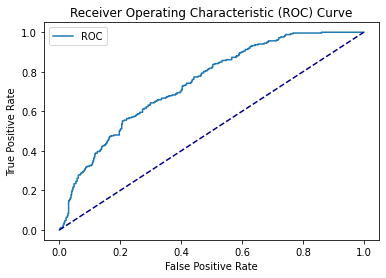

AUC: 0.742


In [167]:
# Naive Bayes
from sklearn.naive_bayes import GaussianNB #or alternative NB implementations

model = GaussianNB()

model.fit(X_train, y_train)
y_pred=model.predict(X_test)



y_probs = model.predict_proba(X_test) 
fpr3,tpr3,AUC3=roc(model,X_train,y_train,X_test,y_test)

## Logistic

In [168]:
# Logistic

from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression()
parameters = {"C":np.arange(1,10,1), "max_iter":[2000] }


logi_f1_train,logi_f1_test=hyperp_search(classifier,parameters)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
f1_train: 0.550868 using {'C': 3, 'max_iter': 2000}


f1         train 0.548   test 0.592


[[429  69]
 [117 135]]


## SUPPORT VECTOR MACHINE

In [169]:
from sklearn.svm import SVC

classifier = SVC()
parameters = {"kernel":['linear','sigmoid','rbf'],
              "C":[0.001,0.1,1,10],
              "degree":[2,3],
              "gamma":[1]}

SV_f1_train,SV_f1_test=hyperp_search(classifier,parameters)


#OVER-FITTING: using {'C': 50, 'kernel': 'rbf'}
# so we omit the 'rbf' among the possible parameters. 

Fitting 3 folds for each of 24 candidates, totalling 72 fits
f1_train: 0.529578 using {'C': 1, 'degree': 2, 'gamma': 1, 'kernel': 'linear'}


f1         train 0.542   test 0.600


[[447  51]
 [122 130]]


## NEURAL NETWORK

In [170]:
# Multi-layer Perceptron classifier

from sklearn.neural_network import MLPClassifier

classifier = MLPClassifier()
parameters = {"activation":[ 'relu'],       #'logistic'],
              "hidden_layer_sizes":[(9,6),(10, 5)], 
              "alpha": [0.001,0.01,1,10],
              "activation":['logistic', 'relu'],
              "learning_rate":['constant'], #'invscaling', 'adaptive'],
              "max_iter": [3000]}



NN_f1_train,NN_f1_test=hyperp_search(classifier,parameters)

#over fitting with: 'alpha': 0.1, 'hidden_layer_sizes': (100, 20, 5), 'max_iter': 2000
#over fitting 

Fitting 3 folds for each of 16 candidates, totalling 48 fits
f1_train: 0.580356 using {'activation': 'logistic', 'alpha': 0.01, 'hidden_layer_sizes': (9, 6), 'learning_rate': 'constant', 'max_iter': 3000}


f1         train 0.620   test 0.626


[[427  71]
 [105 147]]


## RANDOM FOREST 

In [171]:
 from sklearn.ensemble import RandomForestClassifier


classifier= RandomForestClassifier()
parameters = {'n_estimators' :     [8,10,15],
              'criterion' :        ['entropy', 'gini'],
              'max_depth' :        np.arange(5,25,5), 
              'min_samples_split': np.arange(5,10,1),
              'min_samples_leaf' : [2,4,6,8,10]
             };


RF_f1_train,RF_f1_test=hyperp_search(classifier,parameters)

Fitting 3 folds for each of 600 candidates, totalling 1800 fits
f1_train: 0.579256 using {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 10}


f1         train 0.718   test 0.562


[[438  60]
 [130 122]]


## ADA BOOST 

In [172]:
from sklearn.ensemble import AdaBoostClassifier


classifier= AdaBoostClassifier()
parameters = {'n_estimators'  : [7000],
              'learning_rate' : [0.01,0.1]}

ADAB_f1_train,ADAB_f1_test=hyperp_search(classifier,parameters)

Fitting 3 folds for each of 2 candidates, totalling 6 fits
f1_train: 0.576109 using {'learning_rate': 0.01, 'n_estimators': 7000}


f1         train 0.614   test 0.552


[[417  81]
 [125 127]]


In [173]:
F1_TRAIN=[knn_f1_train,tree_f1_train,logi_f1_train,SV_f1_train,NN_f1_train,RF_f1_train,ADAB_f1_train]
F1_TEST= [knn_f1_test, tree_f1_test, logi_f1_test, SV_f1_test, NN_f1_test, RF_f1_test,ADAB_f1_test]
data = {'Name': ['knn','tree','Logistic','SVM','Neural Network','Random Forest','ADABOOST']}
data['f1_train']=F1_TRAIN
data['f1_test']=F1_TEST

data_no_oversampling=pd.DataFrame(data)

In [174]:
data_no_oversampling

,Name,f1_train,f1_test
0,knn,0.604119,0.528217
1,tree,0.652422,0.520085
2,Logistic,0.547529,0.592105
3,SVM,0.541534,0.600462
4,Neural Network,0.620100,0.625532
5,Random Forest,0.718141,0.562212
6,ADABOOST,0.614484,0.552174


## OVER SAMPLING 

We oversample the train data and not the test data since if train data is unbalanced, our validation data will most likely show the same trait and be unbalanced.

In [63]:
print(len(y_train[y_train==0]))
print(len(y_train[y_train==1]))

1394
706


In [64]:
 from sklearn.utils import resample

df_train=pd.concat([X_train,y_train], axis = 1)

#Down-sample Majority Class
#1) Separate majority and minority classes

df_majority = df_train[df_train.failure==0] 
df_minority = df_train[df_train.failure==1] 
#2) Oversample minority class
df_minority_oversampled = resample(df_minority, 
                                   replace=True,
                                   n_samples=len(y_train[y_train==0]),    # number of samples into the minority class 
                                   random_state=123)  # reproducible results
 
#3) Combine oversampled minority class with majority class
df_train_oversampled = pd.concat([df_minority_oversampled, df_majority])
 
#4) Display new class counts
df_train_oversampled.failure.value_counts()

0    1394
1    1394
Name: failure, dtype: int64

In [65]:
y_train=df_train_oversampled['failure']
X_train=df_train_oversampled.loc[:, df_train_oversampled.columns!='failure']

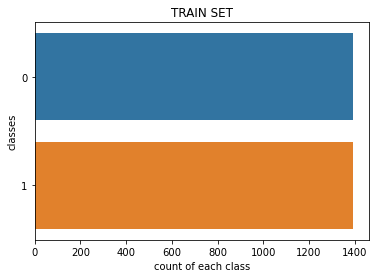

In [66]:
#Visualize Class Counts
sns.countplot(y=y_train[:]) 
plt.xlabel("count of each class")
plt.ylabel("classes")
plt.title("TRAIN SET")
plt.show()

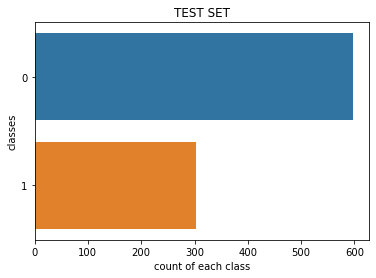

In [67]:
#Visualize Class Counts
sns.countplot(y=y_test[:]) 
plt.xlabel("count of each class")
plt.ylabel("classes")
plt.title("TEST SET")
plt.show()

## KNN - OS

In [70]:
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier()
parameters = {'n_neighbors':np.arange(2,10,1)}
knn_f1_train,knn_f1_test = hyperp_search(classifier,parameters)

print("DIfference between train-test")
print(knn_f1_train-knn_f1_test)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
f1_train: 0.757659 using {'n_neighbors': 3}


f1         train 0.892   test 0.554


[[420 178]
 [118 184]]
DIfference between train-test
0.33815234279336603


## TREE - OS

In [72]:
from sklearn.tree import DecisionTreeClassifier
classifier = DecisionTreeClassifier()
parameters = {'criterion': ['entropy','gini'], 
              'max_depth':         [3,4,5,6],
              'min_samples_split':  np.arange(4,24,4),
              'min_samples_leaf':   [4]}

tree_f1_train,tree_f1_test=hyperp_search(classifier,parameters)
print(tree_f1_train-tree_f1_test)

Fitting 3 folds for each of 40 candidates, totalling 120 fits
f1_train: 0.747931 using {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 4}


f1         train 0.766   test 0.609


[[341 257]
 [ 57 245]]
0.15678930189815254


## LOGISTIC - OS

In [74]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression()
parameters = {"C":[0.15,0.01,1], "max_iter":[1000] }

logi_f1_train,logi_f1_test=hyperp_search(classifier,parameters)
print(logi_f1_train-logi_f1_test)

Fitting 3 folds for each of 3 candidates, totalling 9 fits
f1_train: 0.724351 using {'C': 1, 'max_iter': 1000}


f1         train 0.734   test 0.649


[[413 185]
 [ 68 234]]
0.08486577381863913


## SUPPORT VECTOR MACHINE 

In [98]:
from sklearn.svm import SVC
classifier = SVC()
parameters = {"kernel":['linear','sigmoid','rbf'],
              "C":[0.001,0.01,0.3],
              "degree":[2,3,4],
              "gamma": [1]}

SV_f1_train,SV_f1_test=hyperp_search(classifier,parameters)
print(SV_f1_train-SV_f1_test)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
f1_train: 0.763569 using {'C': 0.01, 'degree': 2, 'gamma': 1, 'kernel': 'linear'}


f1         train 0.786   test 0.622


[[340 158]
 [ 67 185]]
0.1641460249021075


## NEURAL NETWORKS - OS 

In [85]:
from sklearn.neural_network import MLPClassifier

classifier = MLPClassifier()
parameters = {"hidden_layer_sizes":[(5, 2),(12,6)], 
              "max_iter": [3000],
              "alpha":    [1],
              "activation":['logistic', 'relu'],
              "learning_rate":['invscaling']}

NN_f1_train,NN_f1_test=hyperp_search(classifier,parameters)
print(NN_f1_train-NN_f1_test)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
f1_train: 0.739495 using {'activation': 'relu', 'alpha': 1, 'hidden_layer_sizes': (12, 6), 'learning_rate': 'invscaling', 'max_iter': 3000}


f1         train 0.796   test 0.648


[[431 167]
 [ 77 225]]
0.14719543964927684


## RANDOM FOREST CLASSIFIER - OS 

In [187]:
from sklearn.ensemble import RandomForestClassifier

classifier= RandomForestClassifier()
parameters = {'criterion' :        ['entropy', 'gini'],
              'max_depth' :        np.arange(4,5,1),
              'min_samples_leaf' : np.arange(5,30,5),
              'min_samples_split': np.arange(10,500,10),
              'n_estimators' :     np.arange(2,10,1), 
             };

RF_f1_train,RF_f1_test=hyperp_search(classifier,parameters)

Fitting 3 folds for each of 3920 candidates, totalling 11760 fits
f1_train: 0.758529 using {'criterion': 'entropy', 'max_depth': 4, 'min_samples_leaf': 5, 'min_samples_split': 20, 'n_estimators': 7}


f1         train 0.759   test 0.615


[[282 216]
 [ 44 208]]


## ADABOOST OS

In [88]:
from sklearn.ensemble import AdaBoostClassifier


classifier= AdaBoostClassifier()
parameters = {'n_estimators'  : [1000,2000,3000,4000,5000,6000],
              'learning_rate' : [0.001, 0.01]}

ADAB_f1_train,ADAB_f1_test=hyperp_search(classifier,parameters)
print(ADAB_f1_train - ADAB_f1_test)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
f1_train: 0.732005 using {'learning_rate': 0.01, 'n_estimators': 5000}


f1         train 0.762   test 0.644


[[414 184]
 [ 71 231]]
0.11781440259706744


In [189]:
F1_TRAIN=[knn_f1_train,tree_f1_train,logi_f1_train,SV_f1_train,NN_f1_train,RF_f1_train,ADAB_f1_train]
F1_TEST= [knn_f1_test, tree_f1_test, logi_f1_test, SV_f1_test, NN_f1_test, RF_f1_test,ADAB_f1_test]
data = {'Name': ['knn','tree','Logistic','SVM','Neural Network','Random Forest','ADABOOST']}
data['f1_train']=F1_TRAIN
data['f1_test']=F1_TEST

data_oversampling=pd.DataFrame(data)

In [190]:
data_oversampling

,Name,f1_train,f1_test
0,knn,0.727159,0.570992
1,tree,0.763813,0.623626
2,Logistic,0.731190,0.638574
3,SVM,0.741184,0.623974
4,Neural Network,0.771133,0.592845
5,Random Forest,0.758600,0.615385
6,ADABOOST,0.742370,0.619808


## OVERSAMPLING WITH ANOTHER METHOD

Scikit-learn’s imblearn has a class named SMOTETomek that combines the concepts of under-sampling and oversampling techniques, theoretically providing a good compromise between the pros and cons of each.

In [89]:
#same process 
X=pd.concat([num,dummies], axis = 1)
y=df['failure']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size =0.25,   
                                                    stratify=y,        #preserve target propotions (probviamo non stratificata)
                                                    random_state= 321) #fix random seed for replicability
# same scaler
X_train[num.columns] = scaler.transform(X_train[num.columns])
X_test[num.columns] = scaler.transform(X_test[num.columns])

In [90]:
from imblearn.combine import SMOTETomek
smt = SMOTETomek()

X_train, y_train= smt.fit_resample(X_train, y_train)

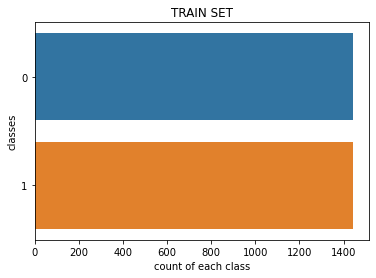

In [91]:
#Visualize Class Counts
sns.countplot(y=y_train[:]) 
plt.xlabel("count of each class")
plt.ylabel("classes")
plt.title("TRAIN SET")
plt.show()

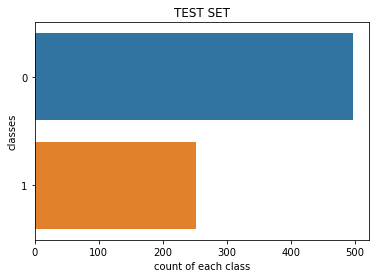

In [92]:
#Visualize Class Counts
sns.countplot(y=y_test[:]) 
plt.xlabel("count of each class")
plt.ylabel("classes")
plt.title("TEST SET")
plt.show()

## SUPPORT VECTOR MACHINE OS 2 

In [93]:
from sklearn.svm import SVC
classifier = SVC()
parameters = {"kernel":['linear','sigmoid','rbf'],
              "C":[0.001,0.01,0.3],
              "degree":[2,3,4],
              "gamma": [1]}

SV_f1_train,SV_f1_test=hyperp_search(classifier,parameters)
print(SV_f1_train-SV_f1_test)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
f1_train: 0.763569 using {'C': 0.01, 'degree': 2, 'gamma': 1, 'kernel': 'linear'}


f1         train 0.786   test 0.622


[[340 158]
 [ 67 185]]
0.1641460249021075


## NEURAL NETWORKS - OS 2

In [95]:
from sklearn.neural_network import MLPClassifier

classifier = MLPClassifier()
parameters = {"hidden_layer_sizes":[(12,6)], 
              "max_iter": [2000],
              "alpha":    [0.1],
              "activation":['logistic', 'relu'],
              "learning_rate":['invscaling']}

NN_f1_train,NN_f1_test=hyperp_search(classifier,parameters)


Fitting 3 folds for each of 2 candidates, totalling 6 fits
f1_train: 0.748409 using {'activation': 'relu', 'alpha': 0.1, 'hidden_layer_sizes': (12, 6), 'learning_rate': 'invscaling', 'max_iter': 2000}


f1         train 0.851   test 0.588


[[402  96]
 [107 145]]


## RANDOM FOREST CLASSIFIER - OS 2

In [103]:
from sklearn.ensemble import RandomForestClassifier

classifier= RandomForestClassifier()
parameters = {'criterion' :        ['entropy', 'gini'],
              'max_depth' :        np.arange(3,5,1),
              'min_samples_leaf' : np.arange(5,30,5),
              'min_samples_split': np.arange(10,50,10),
              'n_estimators' :     np.arange(2,10,1), 
             };

RF_f1_train,RF_f1_test=hyperp_search(classifier,parameters)

Fitting 3 folds for each of 640 candidates, totalling 1920 fits
f1_train: 0.778392 using {'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 5, 'min_samples_split': 20, 'n_estimators': 8}


f1         train 0.793   test 0.619


[[304 194]
 [ 52 200]]


## ADABOOST OS 2 

In [96]:
from sklearn.ensemble import AdaBoostClassifier


classifier= AdaBoostClassifier()
parameters = {'n_estimators'  : [5000],
              'learning_rate' : [0.01]}

ADAB_f1_train,ADAB_f1_test=hyperp_search(classifier,parameters)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
f1_train: 0.758854 using {'learning_rate': 0.01, 'n_estimators': 5000}


f1         train 0.793   test 0.614


[[355 143]
 [ 77 175]]


---

### Considertions